In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

import lightkurve as lk

sys.path.append('/home/kobayashi/project/B4_research/src/')
from plot_tls import get_transit_mask, plot_tls

np.random.seed(seed=0)

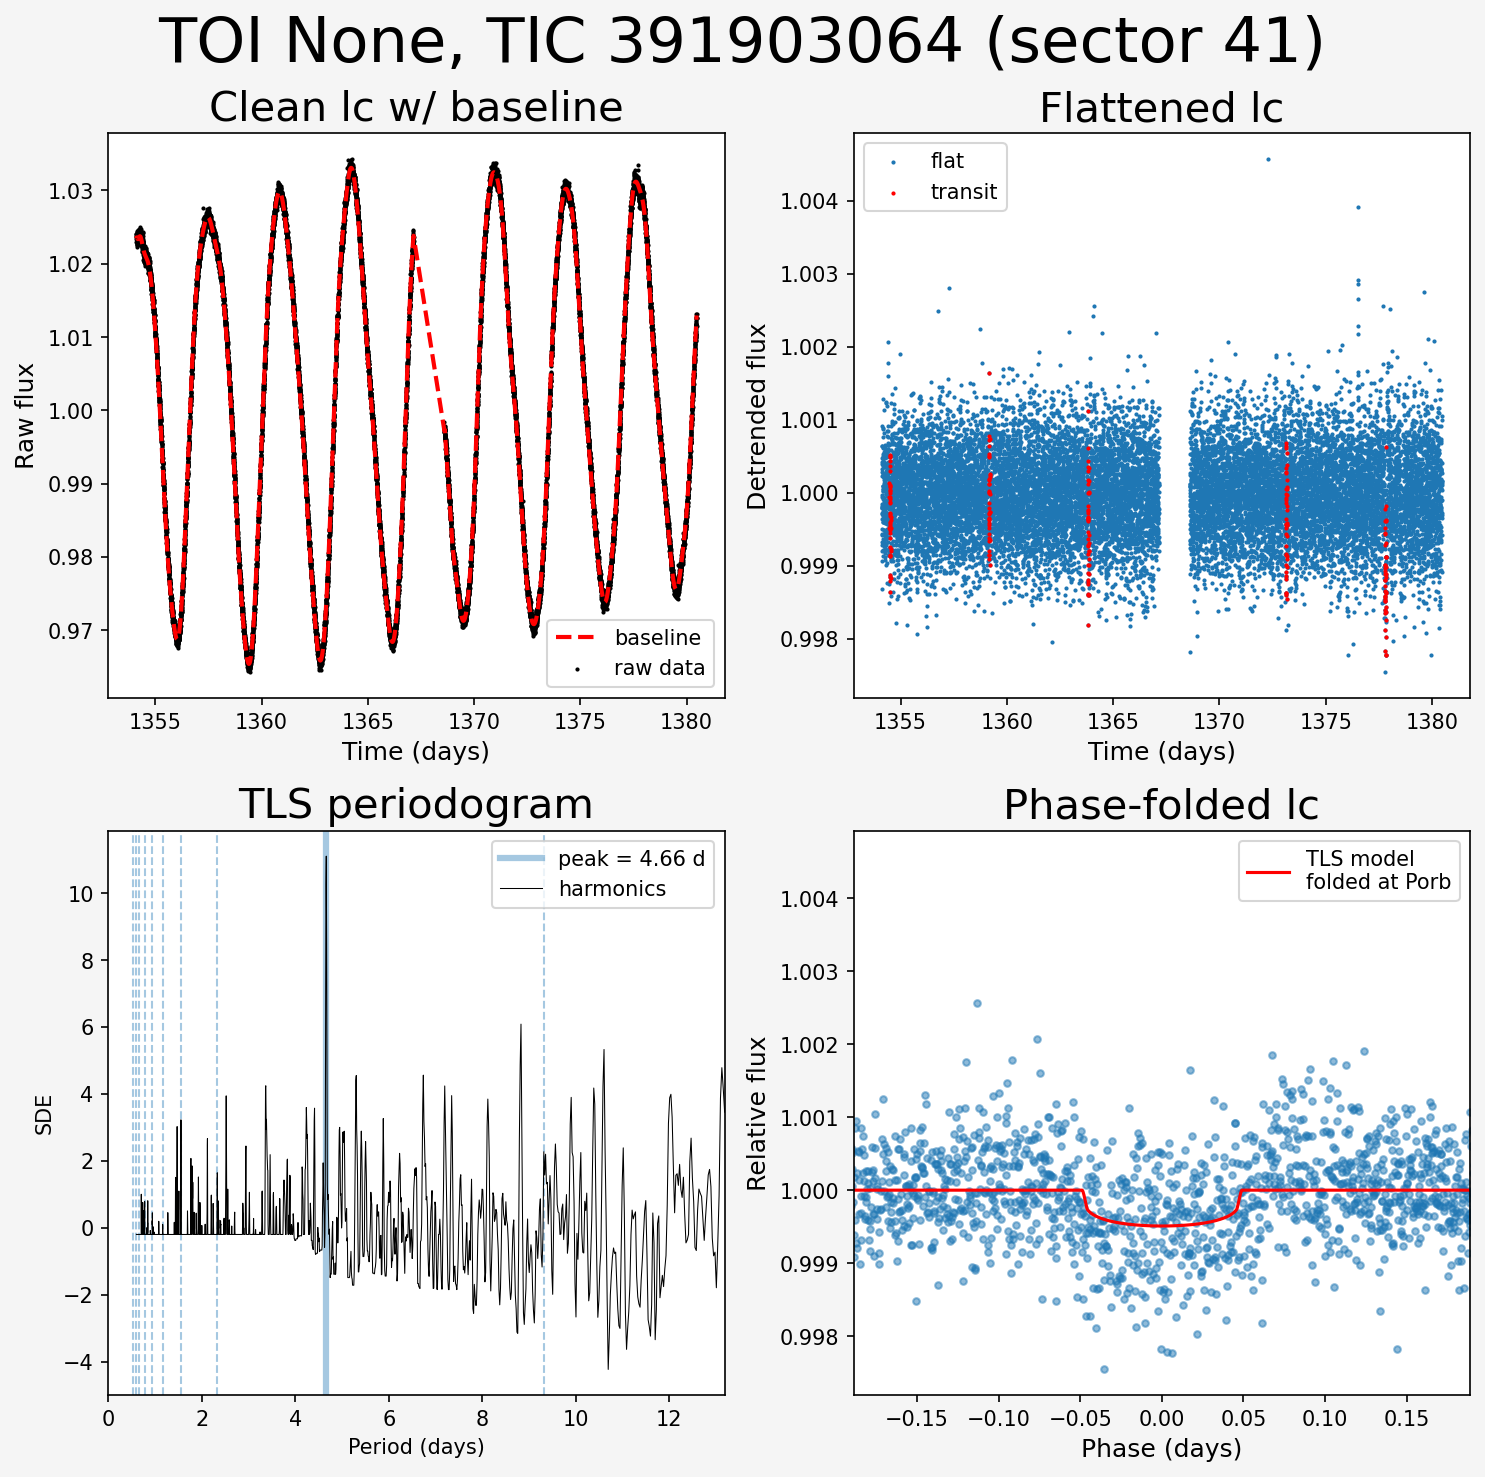

In [12]:
fig = plot_tls(lc_clean, flatten_lc, trend_lc, results)

In [5]:
%%bash
pwd

/home/kobayashi/project/B4_research/homeworks/tls/tutorials


test TLS on TOI 3353 (best targets: https://docs.google.com/presentation/d/10pso2IFyhF0yCCmgqgzqgis5sY6rNz8y0_bP1ie_lRs/edit#slide=id.gf01058bb40_0_0)

In [2]:
%%time
###==============================================
# Load LK
###==============================================

target_star = "TOI 3353"
lc_item = lk.search_lightcurve(target=target_star, author="SPOC", sector=2)
lc = lc_item.download()
lc_clean = lc.normalize().remove_nans().remove_outliers(sigma_lower=20, sigma_upper=10)

CPU times: user 705 ms, sys: 32.6 ms, total: 738 ms
Wall time: 10.8 s


## Run Wotan

In [3]:
from wotan import flatten

# time = lc_clean.time.value
# flux = lc_clean.flux.value
# flatten_lc, trend_lc = flatten(time, flux, window_length=0.4469233898916556, return_trend=True, method='cosine', robust='True')
# from transitleastsquares import transitleastsquares
# model = transitleastsquares(time, flatten_lc1)
# results = model.power()

Iteration: 1 Rejected outliers (total): 201
Iteration: 2 Rejected outliers (total): 236
Iteration: 3 Rejected outliers (total): 240
Converged.
Iteration: 1 Rejected outliers (total): 161
Iteration: 2 Rejected outliers (total): 187
Iteration: 3 Rejected outliers (total): 188
Iteration: 4 Rejected outliers (total): 189
Converged.
Iteration: 1 Rejected outliers (total): 200
Iteration: 2 Rejected outliers (total): 238
Iteration: 3 Rejected outliers (total): 244
Iteration: 4 Rejected outliers (total): 246
Iteration: 5 Rejected outliers (total): 247
Converged.
Iteration: 1 Rejected outliers (total): 171
Iteration: 2 Rejected outliers (total): 203
Iteration: 3 Rejected outliers (total): 208
Iteration: 4 Rejected outliers (total): 207
Converged.
Iteration: 1 Rejected outliers (total): 191
Iteration: 2 Rejected outliers (total): 221
Iteration: 3 Rejected outliers (total): 228
Iteration: 4 Rejected outliers (total): 230
Converged.
Iteration: 1 Rejected outliers (total): 180
Iteration: 2 Rejected

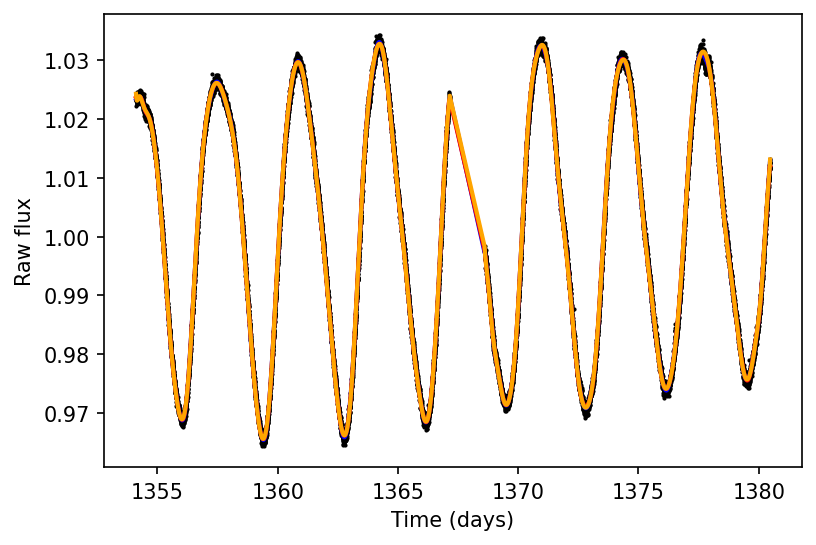

In [4]:
time = lc_clean.time.value
flux = lc_clean.flux.value

flatten_lc1, trend_lc1 = flatten(time, flux, window_length=0.3, return_trend=True, method='cosine', robust='True')
flatten_lc2, trend_lc2 = flatten(time, flux, window_length=0.4, return_trend=True, method='cosine', robust='True')
flatten_lc3, trend_lc3 = flatten(time, flux, window_length=0.5,   return_trend=True, method='cosine', robust='True')
plt.close()
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, linewidth=2, color='blue')  # overfit
plt.plot(time, trend_lc2, linewidth=2, color='red')  # about right
plt.plot(time, trend_lc3, linewidth=2, color='orange')  # underfit
# plt.xlim(0, 2)
# plt.ylim(0.9995, 1.0015)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

In [5]:
flatten_lc = flatten_lc1
trend_lc = trend_lc1

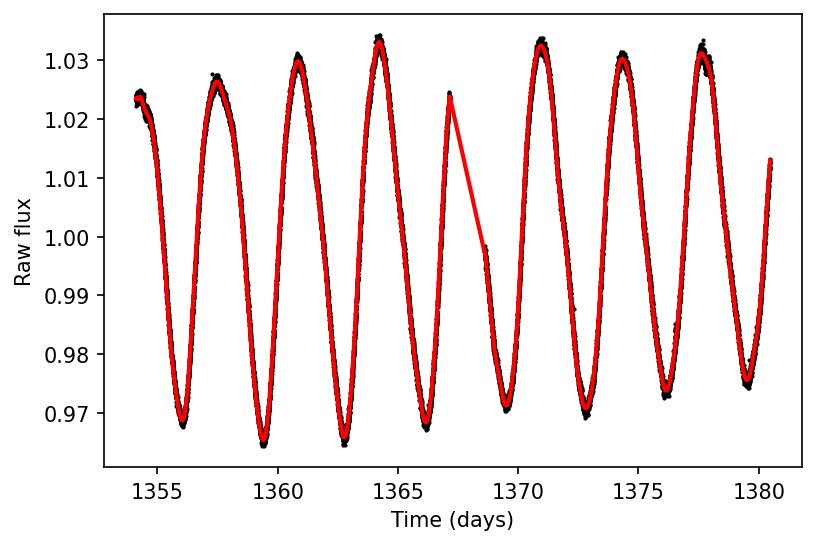

In [6]:
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc, linewidth=2, color='red')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

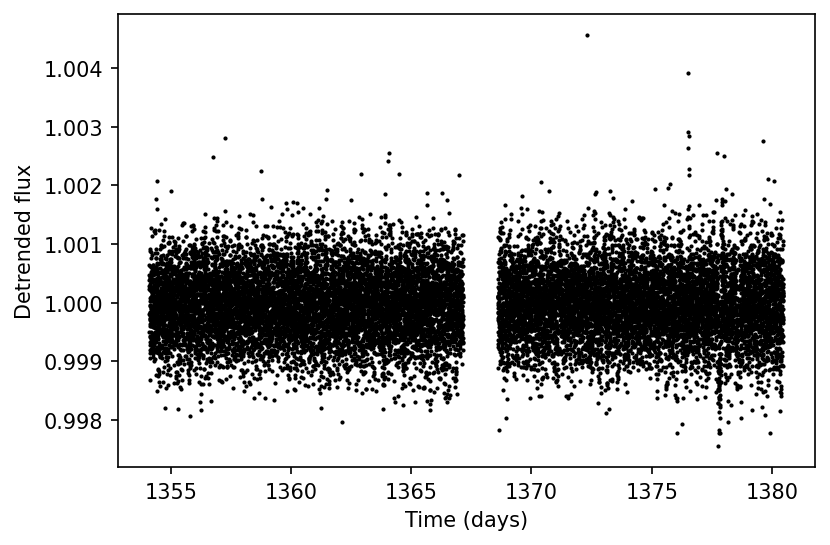

In [7]:
plt.close()
plt.scatter(time, flatten_lc, s=1, color='black')
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
plt.show();

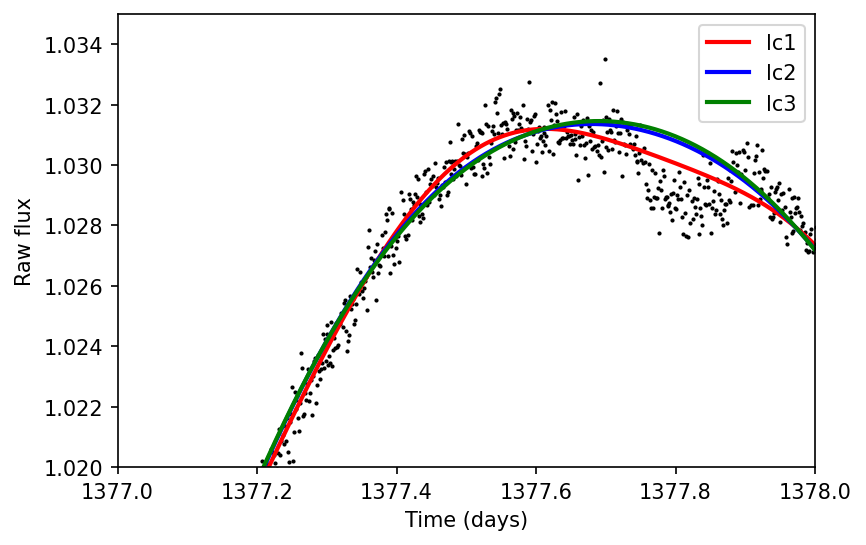

In [8]:
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, linewidth=2, color='red', label="lc1")
plt.plot(time, trend_lc2, linewidth=2, color='blue', label="lc2")
plt.plot(time, trend_lc3, linewidth=2, color='green', label="lc3")
plt.legend()
plt.xlim(1377, 1378)
plt.ylim(1.02, 1.035)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

## Run TLS

In [11]:
###==============================================
# TLS
###==============================================
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flatten_lc1)
results = model.power()

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 17578 data points, 2390 periods from 0.601 to 13.182 days
Using all 4 CPU threads


100%|██████████████████████████████████████████████████████| 2390/2390 periods | 01:43<00:00


In [74]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

Period 4.66205 d
6 transit times in time series: ['1354.50127', '1359.16332', '1363.82537', '1368.48742', '1373.14947', '1377.81152']
Transit depth 0.99951
Best duration (days) 0.09444
Signal detection efficiency (SDE): 11.101450086796358


and visualize the results

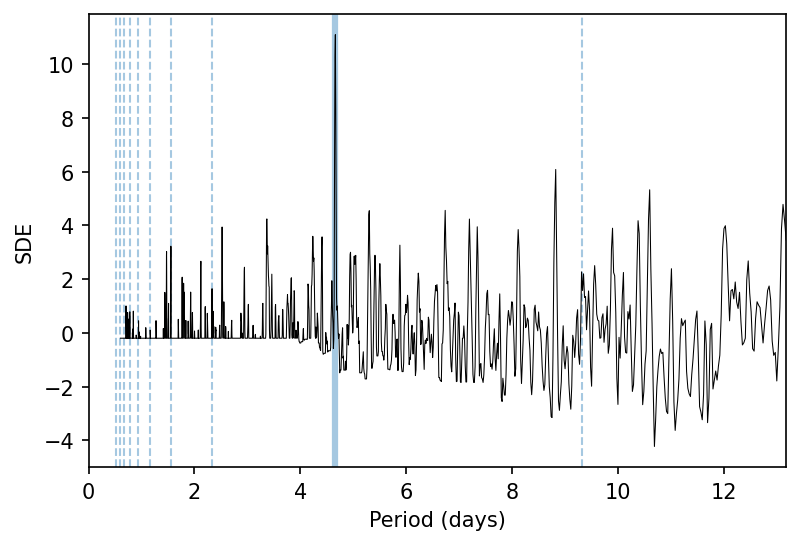

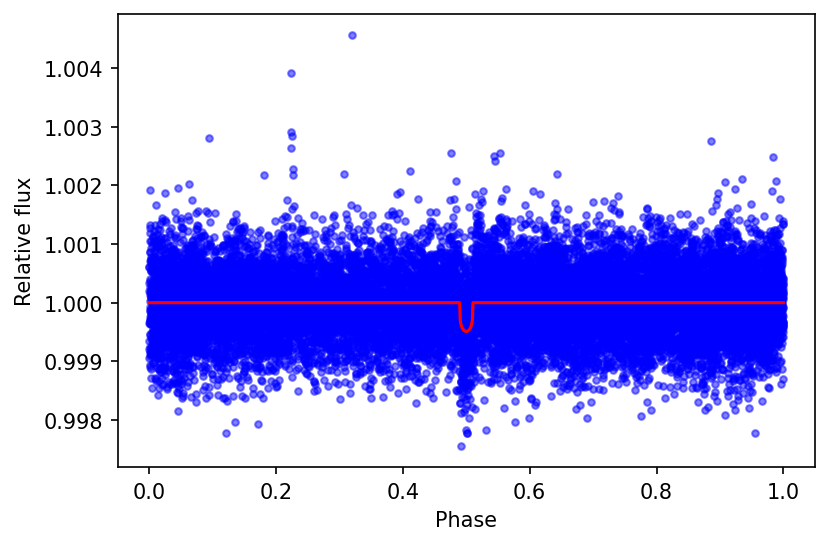

In [11]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period/n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
#plt.xlim(0.48, 0.52)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [54]:
import time
from contextlib import contextmanager
from typing import Optional
import logging
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    yield
    msg = f"[{name}] done in {time.time()-t0:.0f} s"
    if logger:
        logger.info(msg)
    else:
        print(msg)

In [118]:
%%time
temp_fold = lc_clean.fold(period=results.period, epoch_time=results.T0)
fractional_duration = (results.duration * 24 / 24.0) / results.period
phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5)

CPU times: user 44.7 ms, sys: 3.98 ms, total: 48.7 ms
Wall time: 46.1 ms


In [119]:
%%time
transit_mask = np.in1d(lc.time.value, temp_fold.time_original[phase_mask].value)

CPU times: user 2.34 ms, sys: 4 ms, total: 6.33 ms
Wall time: 4.17 ms


In [120]:
sum(transit_mask)

211

In [83]:
print(len(lc_clean.time))
print(len([n for n in set(temp_fold.time_original[phase_mask])]))

17578
211


In [92]:
np.array([n for n in lc_clean.time])

array([<Time object: scale='tdb' format='btjd' value=1354.1083489129337>,
       <Time object: scale='tdb' format='btjd' value=1354.1097377740343>,
       <Time object: scale='tdb' format='btjd' value=1354.111126635135>,
       ...,
       <Time object: scale='tdb' format='btjd' value=1380.4689855213614>,
       <Time object: scale='tdb' format='btjd' value=1380.4703743829823>,
       <Time object: scale='tdb' format='btjd' value=1380.4717632445745>],
      dtype=object)

In [143]:
type(flatten_lc.time)

AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [155]:
lc_clean.sector

2

In [125]:
results
#raw time. flux
        tls_results["time_raw"] = lc.time
        tls_results["flux_raw"] = lc.flux
        tls_results["time_flat"] = flat.time
        tls_results["flux_flat"] = flat.flux
        tls_results["ticid"] = l.ticid
        tls_results["sector"] = l.sector

{'SDE': 11.101450086796358,
 'SDE_raw': 6.474731763765773,
 'chi2_min': 17415.35241968844,
 'chi2red_min': 0.990972597000594,
 'period': 4.662048428900344,
 'period_uncertainty': 0.018595336663450368,
 'T0': 1354.50127289243,
 'duration': 0.09443966392551431,
 'depth': 0.9995091159889025,
 'depth_mean': (0.9995316513842349, 3.687857436939277e-05),
 'depth_mean_even': (0.9996304090502813, 4.184162365796167e-05),
 'depth_mean_odd': (0.9993788856195696, 6.582228999516793e-05),
 'transit_depths': array([0.99971795, 0.99989188, 0.99953913,        nan, 0.99963153,
        0.99891183]),
 'transit_depths_uncertainties': array([6.72421294e-05, 6.63187088e-05, 7.09494848e-05,            nan,
        7.77010521e-05, 7.30443487e-05]),
 'rp_rs': 0.019924920174874797,
 'snr': 14.564448924053899,
 'snr_per_transit': array([ 4.00591576,  1.45441002,  6.4486423 ,  0.        ,  5.07695674,
        15.34086199]),
 'snr_pink_per_transit': array([ 3.68710806,  1.41338491,  6.02469172,  0.        ,  4.81672

In [14]:
results.period, results.T0, results.duration

AttributeError: 'float' object has no attribute 'type'

0.008144140243530273


/home/kobayashi/miniconda3/envs/py3/lib/python3.9/site-packages/astropy/timeseries/sampled.py:230: RuntimeWarning: invalid value encountered in remainder
  relative_time_sec = (((self.time - epoch_time).sec


ValueError: Input values did not match the format class jd:
TypeError: Input values for jd class must be finite doubles

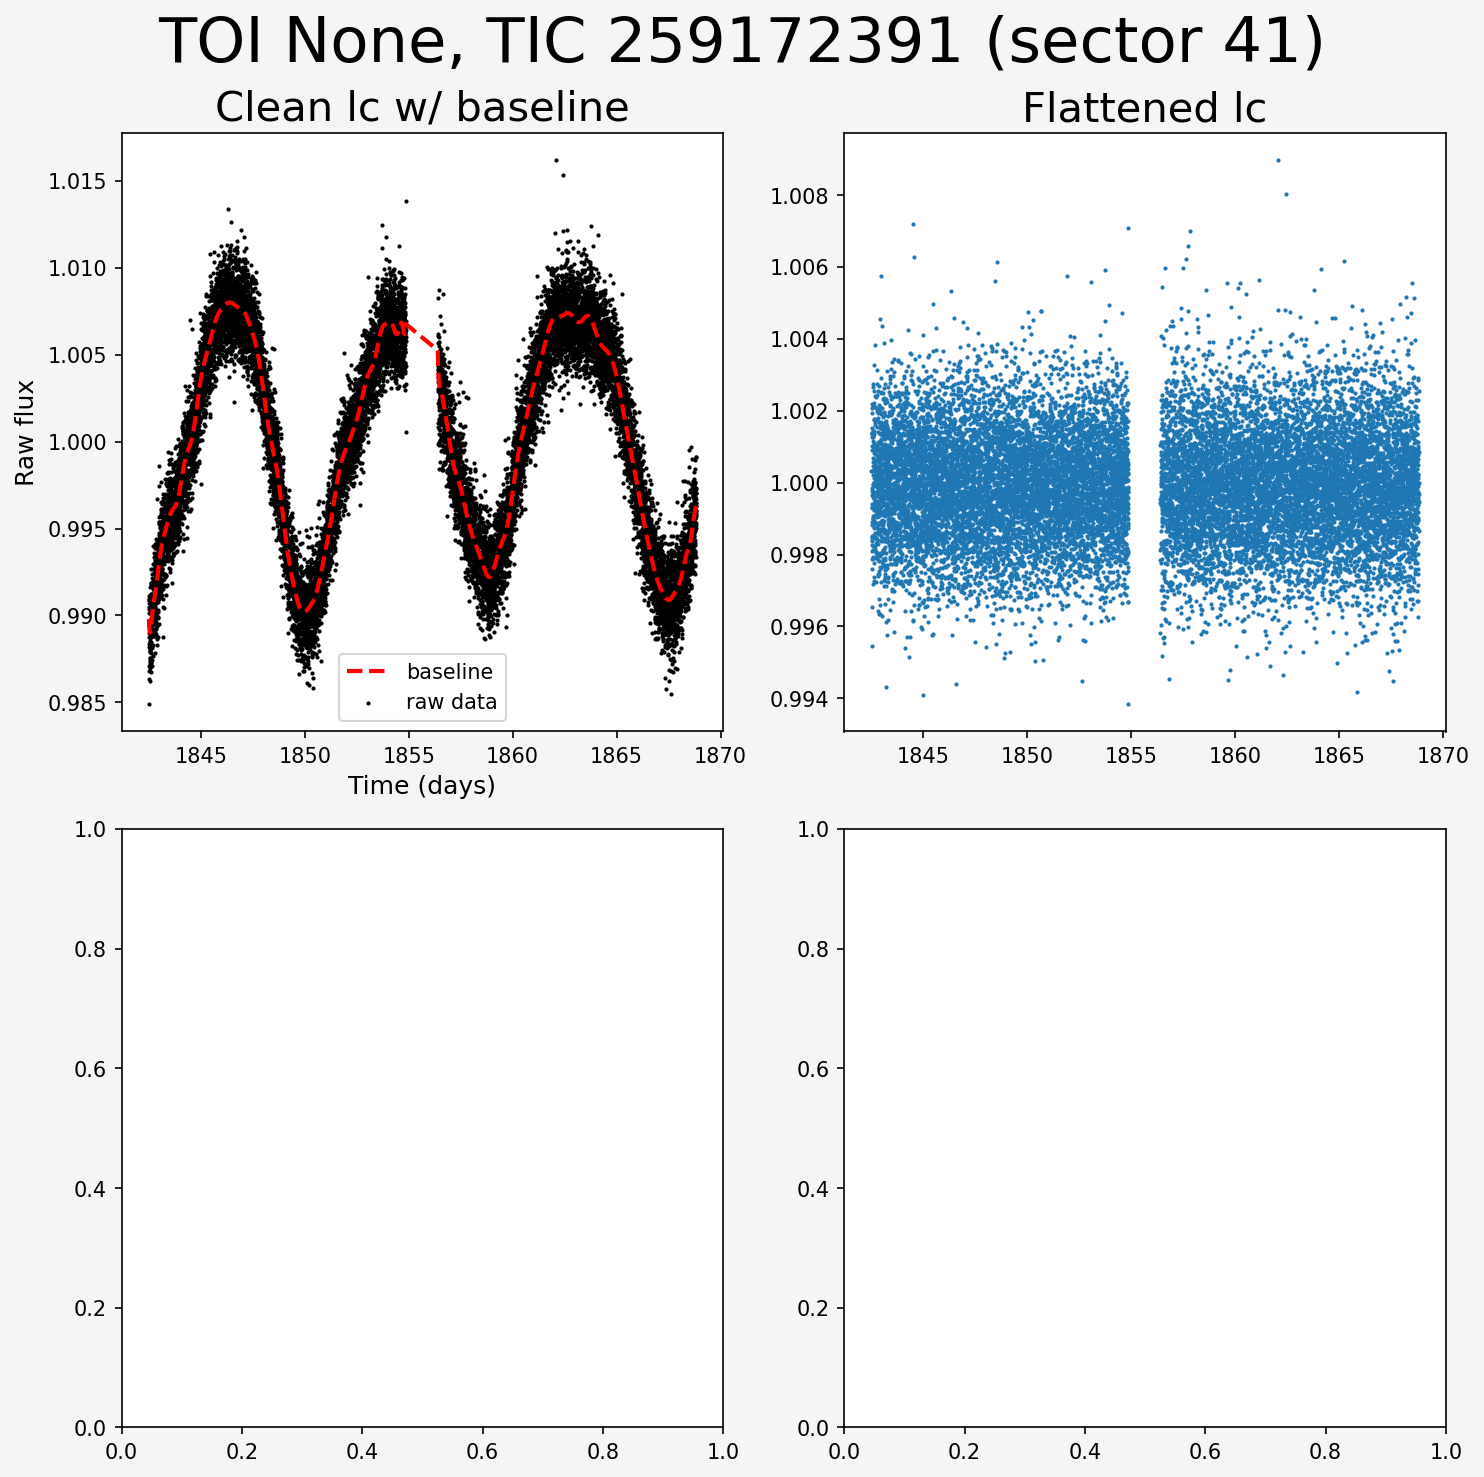

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import time as T
def get_transit_mask(lc, period, epoch, duration_hours):
    """
    lc : lk.LightCurve
        lightcurve that contains time and flux properties
    Another version using numpy arrays only
    ---------------------------------------
    mask = []
    t0 += np.ceil((time[0] - dur - t0) / period) * period
    for t in np.arange(t0, time[-1] + dur, period):
        mask.extend(np.where(np.abs(time - t) < dur / 2.)[0])
    return  np.array(mask)
    """
    assert isinstance(lc, lk.LightCurve)
    assert (
        (period is not None)
        & (epoch is not None)
        & (duration_hours is not None)
    )
    temp_fold = lc.fold(period, epoch_time=epoch)
    fractional_duration = (duration_hours / 24.0) / period
    phase_mask = np.abs(temp_fold.phase) < (fractional_duration * 1.5) #np.array([n for n in set(arr2)], dtype=object)
    transit_mask = np.in1d(lc.time.value, temp_fold.time_original[phase_mask].value)
    return transit_mask


"""Plot a figure for TLS pipline
This function returns a figure containing 1. clean lc w/ baseline 2. flatten lc 3. periodgram of transit 4. phase folded lc
----------
Args:
    lc_clean : 'lightkurve.lightcurve.TessLightCurve' object
                    from preprocessed lk.search_lightcurve(target) func.
    flatten_lc : 'numpy.ndarray' object
                    from wotan.flatten() func.
    trend_lc : 'numpy.ndarray' object
                    from wotan.flatten() func.
    results : 'transitleastsquares.results.transitleastsquaresresults' object
                    from transitleastsquares.transitleastsquares(time, flatten_lc) func.
----------
Returns:
    fig : 'matplotlib.figure.Figure' object
"""

assert isinstance(lc_clean, lk.LightCurve)
assert isinstance(flatten_lc, np.ndarray)
assert isinstance(trend_lc, np.ndarray)
assert isinstance(results, dict)
    
time = lc_clean.time.value
flux = lc_clean.flux.value

fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True, facecolor="whitesmoke")
fig.suptitle(f"TOI {None}, TIC {lc_clean.TICID} (sector {41})", fontsize=30) # have to update TOI & sector args
axes = axes.flatten()

# 1. clean lc w/ baseline
t0 = T.time()

ax = axes[0]
ax.set_title('Clean lc w/ baseline', fontsize=20)
ax.scatter(time, flux, s=1, color='black', label="raw data")
ax.plot(time, trend_lc, linewidth=2, color='red', label="baseline", linestyle='dashed')
ax.legend(loc='best')
ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('Raw flux', fontsize=12)

print(T.time() - t0)

# 2. Flatten lc
t0 = T.time()

ax = axes[1]
ax.set_title('Flattened lc', fontsize=20)
ax.scatter(time, flatten_lc, s=1, label='flat')
# mask = [False] * len(time)
# for i in range(int((time.max() - results.T0)//results.period) + 1):
#     mask |= (time >= results.T0 + i * results.period - 5*results.period_uncertainty) & (time <= results.T0 + i * results.period + 5*results.period_uncertainty)
t1 = T.time()
mask = get_transit_mask(
            lc_clean, results.period, results.T0, results.duration * 24
        )
print(T.time() - t1)
ax.scatter(time[mask], flatten_lc[mask], s=1, color="red", label='transit')
ax.legend()
ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('Detrended flux', fontsize=12)

print(T.time() - t0)

# 3. Transit Least Squares SDE
t0 = T.time()

ax = axes[2]
ax.axvline(results.period, alpha=0.4, lw=3, label=f"peak = {results.period}")
ax.set_xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period/n, alpha=0.4, lw=1, linestyle="dashed")
ax.set_title('TLS periodogram', fontsize=20)
ax.set_ylabel(r'SDE')
ax.set_xlabel('Period (days)')
ax.plot(results.periods, results.power, color='black', lw=0.5, label="Othe periods [d]")
ax.legend()
ax.set_xlim(0, max(results.periods))

print(T.time() - t0)

# 4. Folded lc
t0 = T.time()

ax = axes[3]
ax.plot((results.model_folded_phase-0.5)*results.period, results.model_folded_model, color='red', label="TLS model \nfolded at Porb")
ax.scatter((results.folded_phase-0.5)*results.period, results.folded_y, s=10, zorder=2, alpha=0.5)
ax.set_title('Phase-folded lc', fontsize=20)
# zoom-in to transit center
ax.set_xlim(-results.duration,results.duration)
#plt.xlim(0.48, 0.52)
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('Phase (days)')
ax.set_ylabel('Relative flux')
ax.legend()

print(T.time() - t0)


In [14]:
lc_clean.__dict__

{'_required_columns_relax': True,
 '_required_columns': ['time', 'flux', 'flux_err'],
 '_masked': False,
 '_column_class': astropy.table.column.Column,
 'columns': <TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>,
 'formatter': <astropy.table.pprint.TableFormatter at 0x7fd6be3290d0>,
 '_copy_indices': True,
 '_init_indices': True,
 'primary_key': ('time',),
 '_meta': {'INHERIT': True,
  'EXTNAME': 'PRIMARY',
  'EXTVER': 1,
  'SIMDATA': False,
  'TELESCOP': 'TESS',
  'INSTRUME': 'TESS Photometer',
  'OBJECT': 'TIC 391903064',
  'TICID': 391903064,
  'RADESYS': 'ICRS',
  'RA_OBJ': 106.529919370023,
  'DEC_OBJ': -75.8197255453163,
  'EQUINOX': 2000.0,
  'EXPOSURE': 21.70590719483,
  'TIMEREF': 'SOLARSYSTEM

In [ ]:
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    yield
    msg = f"[{name}] done in {time.time()-t0:.0f} s"
    if logger:
        logger.info(msg)
    else:
        print(msg)

In [15]:
def plot_tls(lc_clean, flatten_lc, trend_lc, result):
    """Plot a figure for TLS pipline

    This function returns a figure containing 1. clean lc w/ baseline 2. flatten lc 3. periodgram of transit 4. phase folded lc

    ----------

    Args: 
        lc_clean : 'lightkurve.lightcurve.TessLightCurve' object 
                        from preprocessed lk.search_lightcurve(target) func.
        flatten_lc : 'numpy.ndarray' object
                        from wotan.flatten() func.
        trend_lc : 'numpy.ndarray' object
                        from wotan.flatten() func.
        result : 'transitleastsquares.results.transitleastsquaresresults' object
                        from transitleastsquares.transitleastsquares(time, flatten_lc) func.

    ----------
    
    Returns:
        
    """
    time = lc_clean.time.value
    flux = lc_clean.flux.value

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True, facecolor="whitesmoke")
    fig.suptitle(f"TOI {None}, TIC {lc_clean.TICID} (sector {41})", fontsize=30) # have to update TOI & sector args
    axes = axes.flatten()

    # 1. clean lc w/ baseline
    ax = axes[0]
    ax.set_title('Clean lc w/ baseline', fontsize=20)
    ax.scatter(time, flux, s=1, color='black', label="row data")
    ax.plot(time, trend_lc, linewidth=2, color='red', label="base line curve", linestyle='dashed')
    ax.legend(loc='best')
    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Raw flux', fontsize=12)

    # 2. Flatten lc
    ax = axes[1]
    ax.set_title('Flatten lc', fontsize=20)
    ax.scatter(time, flatten_lc, s=1, label='flat')
    mask = [False] * len(time)
    for i in range(int((time.max() - results.T0)//results.period) + 1):
        mask |= (time >= results.T0 + i * results.period - 5*results.period_uncertainty) & (time <= results.T0 + i * results.period + 5*results.period_uncertainty)
    ax.scatter(time[mask], flatten_lc[mask], s=1, color="red", label='transit')
    ax.legend()
    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Detrended flux', fontsize=12)

    # 3. Transit Least Squares SDE
    ax = axes[2]
    ax.axvline(results.period, alpha=0.4, lw=3, label=f"peak = {results.period}")
    ax.set_xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period/n, alpha=0.4, lw=1, linestyle="dashed")
    ax.set_title('Transit Least Squares SDE', fontsize=20)
    ax.set_ylabel(r'SDE')
    ax.set_xlabel('Period (days)')
    ax.plot(results.periods, results.power, color='black', lw=0.5, label="Othe periods [d]")
    ax.legend()
    ax.set_xlim(0, max(results.periods))

    # 4. Folded lc
    ax = axes[3]
    ax.plot(results.model_folded_phase, results.model_folded_model, color='red', label="TLS model \nfoled at Prot")
    ax.scatter(results.folded_phase, results.folded_y, s=10, zorder=2, alpha=0.5)
    #plt.xlim(0.48, 0.52)
    ax.ticklabel_format(useOffset=False)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Relative flux')
    ax.legend()
    
    return fig

In [16]:
type(fig)

matplotlib.figure.Figure

0.12054610252380371


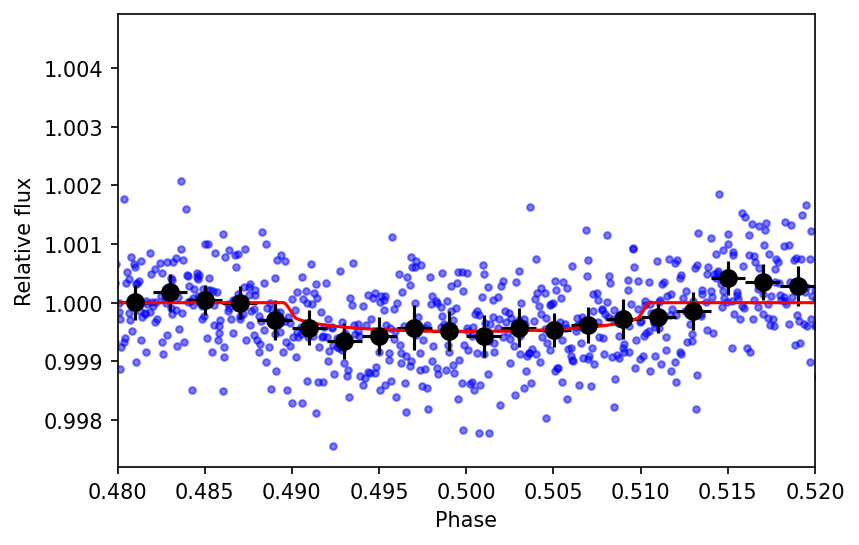

In [63]:
from scipy import stats
t0 = T.time()
bins = 500
bin_means, bin_edges, binnumber = stats.binned_statistic(
    results.folded_phase,
    results.folded_y,
    statistic='mean',
    bins=bins)
bin_stds, _, _ = stats.binned_statistic(
    results.folded_phase,
    results.folded_y,
    statistic='std',
    bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.errorbar(
    bin_centers,
    bin_means,
    yerr=bin_stds/2,
    xerr=bin_width/2,
    marker='o',
    markersize=8,
    color='black',
    #capsize=10,
    linestyle='none')
plt.xlim(0.48, 0.52)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Phase')
plt.ylabel('Relative flux');
print(T.time()- t0)

Questions:<br>
what is the error message of Load LK cell ??? <br>
how does the baseline function works??? <br>
Do I need preprocess the lc??? <br>

In [19]:
sum(np.isnan(flatten_lc))

0

In [25]:
target_star = "TOI 1445"
lc_item = lk.search_lightcurve(target=target_star, author="SPOC", sector=20)
lc = lc_item.download()
lc_clean = lc.normalize().remove_nans().remove_outliers(sigma_lower=20, sigma_upper=10)

In [26]:
from wotan import flatten

time = lc_clean.time.value
flux = lc_clean.flux.value
flatten_lc, trend_lc = flatten(time, flux, window_length=0.4469233898916556, return_trend=True, method='cosine', robust='True')
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flatten_lc)
results = model.power()

Iteration: 1 Rejected outliers (total): 178
Iteration: 2 Rejected outliers (total): 201
Iteration: 3 Rejected outliers (total): 204
Iteration: 4 Rejected outliers (total): 205
Iteration: 5 Rejected outliers (total): 206
Converged.
Iteration: 1 Rejected outliers (total): 180
Iteration: 2 Rejected outliers (total): 214
Iteration: 3 Rejected outliers (total): 216
Converged.
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 17633 data points, 2385 periods from 0.601 to 13.159 days
Using all 4 CPU threads


100%|█████████████████████████████████████████████| 2385/2385 periods | 01:59<00:00
/home/kobayashi/miniconda3/envs/py3/lib/python3.9/site-packages/transitleastsquares-1.0.28-py3.9.egg/transitleastsquares/main.py:199: UserWarning: No transit were fit. Try smaller "transit_depth_min"
  warnings.warn('No transit were fit. Try smaller "transit_depth_min"')


In [24]:
results

{'SDE': 0,
 'SDE_raw': 0,
 'chi2_min': 17633.0,
 'chi2red_min': 1.0002268988598333,
 'period': nan,
 'period_uncertainty': -6.278421981074972,
 'T0': 0,
 'duration': nan,
 'depth': 1,
 'depth_mean': (nan, nan),
 'depth_mean_even': (nan, nan),
 'depth_mean_odd': (nan, nan),
 'transit_depths': nan,
 'transit_depths_uncertainties': nan,
 'rp_rs': nan,
 'snr': nan,
 'snr_per_transit': nan,
 'snr_pink_per_transit': nan,
 'odd_even_mismatch': nan,
 'transit_times': nan,
 'per_transit_count': nan,
 'transit_count': nan,
 'distinct_transit_count': nan,
 'empty_transit_count': nan,
 'FAP': nan,
 'in_transit_count': nan,
 'after_transit_count': nan,
 'before_transit_count': nan,
 'periods': array([ 0.60149548,  0.60198202,  0.60246908, ..., 13.09949873,
        13.12911768, 13.15882598]),
 'power': array([0., 0., 0., ..., 0., 0., 0.]),
 'power_raw': array([0., 0., 0., ..., 0., 0., 0.]),
 'SR': 0,
 'chi2': array([17633., 17633., 17633., ..., 17633., 17633., 17633.]),
 'chi2red': array([1.0002269,

In [6]:
results

{'SDE': 0,
 'SDE_raw': 0,
 'chi2_min': 17633.0,
 'chi2red_min': 1.0002268988598333,
 'period': nan,
 'period_uncertainty': -6.278421981074972,
 'T0': 0,
 'duration': nan,
 'depth': 1,
 'depth_mean': (nan, nan),
 'depth_mean_even': (nan, nan),
 'depth_mean_odd': (nan, nan),
 'transit_depths': nan,
 'transit_depths_uncertainties': nan,
 'rp_rs': nan,
 'snr': nan,
 'snr_per_transit': nan,
 'snr_pink_per_transit': nan,
 'odd_even_mismatch': nan,
 'transit_times': nan,
 'per_transit_count': nan,
 'transit_count': nan,
 'distinct_transit_count': nan,
 'empty_transit_count': nan,
 'FAP': nan,
 'in_transit_count': nan,
 'after_transit_count': nan,
 'before_transit_count': nan,
 'periods': array([ 0.60149548,  0.60198202,  0.60246908, ..., 13.09949873,
        13.12911768, 13.15882598]),
 'power': array([0., 0., 0., ..., 0., 0., 0.]),
 'power_raw': array([0., 0., 0., ..., 0., 0., 0.]),
 'SR': 0,
 'chi2': array([17633., 17633., 17633., ..., 17633., 17633., 17633.]),
 'chi2red': array([1.0002269,

In [8]:
import flammkuchen as fk

fk.save("sample.h5", results)

In [9]:
results2 = fk.load("sample.h5")

In [10]:
results2

{'chi2': array([17633., 17633., 17633., ..., 17633., 17633., 17633.]),
 'chi2red': array([1.0002269, 1.0002269, 1.0002269, ..., 1.0002269, 1.0002269,
        1.0002269]),
 'depth_mean': (nan, nan),
 'depth_mean_even': (nan, nan),
 'depth_mean_odd': (nan, nan),
 'periods': array([ 0.60149548,  0.60198202,  0.60246908, ..., 13.09949873,
        13.12911768, 13.15882598]),
 'power': array([0., 0., 0., ..., 0., 0., 0.]),
 'power_raw': array([0., 0., 0., ..., 0., 0., 0.]),
 'FAP': nan,
 'SDE': 0,
 'SDE_raw': 0,
 'SR': 0,
 'T0': 0,
 'after_transit_count': nan,
 'before_transit_count': nan,
 'chi2_min': 17633.0,
 'chi2red_min': 1.0002268988598333,
 'depth': 1,
 'distinct_transit_count': nan,
 'duration': nan,
 'empty_transit_count': nan,
 'folded_dy': nan,
 'folded_phase': nan,
 'folded_y': nan,
 'in_transit_count': nan,
 'model_folded_model': nan,
 'model_folded_phase': nan,
 'model_lightcurve_model': nan,
 'model_lightcurve_time': nan,
 'odd_even_mismatch': nan,
 'per_transit_count': nan,
 